# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import time
from itertools import count
import matplotlib.pyplot as plt
%matplotlib inline

from multi_agent import MultiAgent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

In [2]:
env = UnityEnvironment(file_name='Tennis')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Train the agent

In [5]:
agent = MultiAgent(agent_count=2, state_size=state_size, action_size=action_size, random_seed=2)

In [6]:
def ddpg(n_episodes=10000):
    scores_deque = deque(maxlen=100)
    scores_global = []
    solved = False

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent.reset()

        score_average = 0
        for t in count():
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]     # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states
            scores += rewards
            
            if np.any(dones):
                break 
                
        # Score for last episode averaged over agents
        score = np.mean(scores)
        
        # Save to last 100 episodes average
        scores_deque.append(score)
        scores_global.append(score)
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.5f}'.format(i_episode, np.mean(scores_deque)))

        if np.mean(scores_deque)>=0.5:
#         if i_episode == 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.5f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.agents[0].actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent.agents[0].critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(agent.agents[1].actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent.agents[1].critic_local.state_dict(), 'checkpoint_critic_1.pth')
            break 
    
            
    return scores_global

scores = ddpg()


/Users/simon/dev/ddpg-multi-agent-udacity/ddpg_agent.py:102: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: -0.00
Episode 200	Average Score: -0.00
Episode 300	Average Score: -0.00
Episode 400	Average Score: -0.00
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.02
Episode 800	Average Score: 0.03
Episode 900	Average Score: 0.04
Episode 1000	Average Score: 0.18
Episode 1100	Average Score: 0.41

Environment solved in 1122 episodes!	Average Score: 0.50810


Text(0.5, 0, 'Episode #')

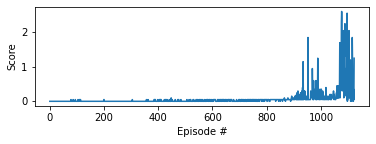

In [7]:
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

### 4. Watch a smart agent

In [8]:
agent.agents[0].actor_local.load_state_dict(torch.load('checkpoint_actor_0.pth'))
agent.agents[0].critic_local.load_state_dict(torch.load('checkpoint_critic_0.pth'))
agent.agents[1].actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth'))
agent.agents[1].critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))

env_info = env.reset(train_mode=False)[brain_name]

## Watch the agent performing in the environment
scores_episode = np.zeros(num_agents)
for i in range(5000):
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]
    states = env_info.vector_observations
    rewards = env_info.rewards
    scores_episode += rewards

print('Score for this episode: {:.2f}'.format(scores_episode.mean()))

Score for this episode: 8.73


In [9]:
env.close()